In [1]:
import numpy as np
import pandas as pd
#from OT_ST import *
#from phase_plots import *
from data_frame_tools import *
import matplotlib.pyplot as plt
import ot
import ot.plot
import pickle
from sklearn.manifold import TSNE,MDS
import networkx as nx
import hypernetx as hnx
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KernelDensity
import pickle
import random
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from sklearn.manifold import TSNE
from Euclidean import Euclidean
from MeasureSpace import MeasureSpace

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


In [2]:
def prep_phase(bandwith, neuron_df, lick_df):
    
    kde_scores = np.zeros(shape = (len(neuron_df['Taste'].unique()),1000))
    
    for taste in neuron_df['Taste'].unique():
        tn=neuron_df[(neuron_df['Taste'].isin([taste]))]
        tl=lick_df[(lick_df['Taste'].isin([taste]))]
        
        ty=split_data_Li(tn,tl)
        log_dens_scores = apply_kde(ty, bandwith, taste)
        
        if len(neuron_df['Taste'].unique()) == 1:
            kde_scores[0,:] = log_dens_scores
        else:
            kde_scores[taste,:] = log_dens_scores
        
    return kde_scores  

def apply_kde(yvals, bw_size, changer):
    
    #sum yvals rows into one vector
    ysum = np.sum(yvals, axis=0)
    vals = np.nonzero(ysum)
    kde_input = vals[0][:, np.newaxis]
    
    if kde_input.shape ==(0,1):
        # IF WE HAVE NO INFORMATION ON THE PHASE, MAKE IT A UNIFORM VALUE (THAT INT. TO ONE)
        distribution_height = 1 / (999)
        log_dens_scores = np.array([distribution_height] * 1000)
    else:
        kde = KernelDensity(kernel="gaussian", bandwidth=bw_size).fit(kde_input)
        all_x=np.array([i for i in range(1000)])[:, np.newaxis]
        scores = kde.score_samples(all_x)
        log_dens_scores = np.exp(scores)
    
    return log_dens_scores

def split_data_Li(neuronDF, licksDF):
    #this fctn takes dataframes and splits off the first 5 lI of data, writes in np arrray. 
    
    yvals = np.zeros(shape=(len(licksDF),1000))
    for row in range(len(licksDF)):
        y = np.zeros(1000)
        
        l = np.array(licksDF.iloc[row, 4:]).astype(int)
        ltimes = np.nonzero(l)
        
        nfires = np.array(neuronDF.iloc[row, 4:]).astype(float)
        
        if len(ltimes[0]) >= 6:
            nfires = nfires[ltimes[0][0]:ltimes[0][5]]
            li_len = ltimes[0][5] - ltimes[0][0]
        else:
            nfires = nfires
            li_len = len(nfires)
        
        
        if sum(nfires) != 0.0:
        #tspikes tells you times of where spikes should fall
            n=np.nonzero(nfires)
            tspikes = np.array([nf/li_len for nf in n])
            #(np.nonzero(nfires)/(li_len)) #+ li
            tspikes = ((np.round(tspikes, decimals=3))*1000).astype(int)
        
            for i in tspikes[0]:
                if 0 <= i < 1000:
                    y[i] = 1.0
        
            yvals[row,:] = y
    
    return yvals

def SVM_one_neuron(X, y, num_splits, RandState, test_size):
    
    # Which SVM Optimization problem do we solve?
    n_samples = X.shape[0] * (1-test_size) # Number of spike trains in the training set
    n_features = X.shape[1]  # Number of time points in the spike trains
    dual_param = (n_samples < n_features)

    # Define the SVM model
    model_SVM = LinearSVC(dual=dual_param, max_iter=10000, tol = 0.0001, random_state=651)
    #add a tolerance here - what happens if tol is 0.001 instead of 0.0001?


    #for j in range(num_splits):   

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=RandState,shuffle = True,stratify=y)   

    model_SVM.fit(X_train,y_train)                   # Re-fit the classifier with the training set
    split_crs = model_SVM.score(X_test,y_test)  # Fit the testing set and record score

    return split_crs

In [3]:
def wfr_r1(delta, taste, tastex, max_steps, eps):
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    tastex=tastex/1000.0
    ls=[]
    for i in range(0,5):
        ls+=[torch.from_numpy(np.concatenate([tastex[i].transpose(),
                                              np.expand_dims(taste[i],axis=1)],axis=1)).transpose(0,1).to(device)]
    Rn = Euclidean(1)
    MonS = MeasureSpace(Rn, delta)
    d = MonS.dissimilarity(ls, max_steps, eps)
    
    return d

## Import data, grab list of coding neurons

In [4]:
with open('C:/Users/nasha/OneDrive - Florida State University/BertramNeuroProj/Synthetic_Project/Bayesian Analysis notebooks/BayesScores_15split.pkl', 'rb') as f:
    neuron_vs_score = pickle.load(f)

In [5]:
first_column = neuron_vs_score[:, 0]
second_column = neuron_vs_score[:, 1]
#mask = second_column > (np.mean(second_column) + np.std(second_column))
mask = second_column > 0.4
coding_neurons = first_column[mask].tolist()
#coding_neurons = first_column.tolist()

In [6]:
len(coding_neurons)

12

In [7]:
neuron_vs_score[354]

array([354.        ,   0.57272727])

Consider the data as we have it in this notebook: look at each neuron's responses independently. For each neuron, we create a TastexTaste matrix where each entry Aij is the distance between that neuron's Phase or Rate responses to those two tastes. if the Aij entry is bigger than the mean+sd of distances between those tastes accross all neurons, we say that our neuron can "distinguish" this taste pair. (for example, for neuron 48, A02 is 0.5. that signifies that the distance between the phase responses to taste 0 and taste 2 for this neuron is 0.5, and if this is higher than the population mean+sd, we say that neuron 48 can distinguish tastes 0 and 2 from each other.)

## Calculate WFR distances between distributions

In [8]:
clean_spike_train_df =pd.read_pickle(
'C:/Users/nasha/OneDrive - Florida State University/TomRichard/Paper/dataFolder/clean_spike_train_df.pickle')

In [9]:
ls_d_p=[]
ls_d_r=[]
#delta=0.0001
delta = 0.5
max_steps=10000
eps=.00001

In [10]:
post_stim = truncate(clean_spike_train_df)
neuronDF = post_stim[(post_stim['Recording Type'] == 'Neuron')]
LickDF = post_stim[(post_stim['Recording Type'] == 'Lick')]

### Detour: plot an example spike train after some treatment 
this plot shows ST in the state it will be fed into our KDE

In [30]:
test = np.sum(ty, axis = 0)
#test = np.nonzero(test)
#test = test[0][:, np.newaxis]
test[200:400]

array([1., 0., 0., 1., 1., 0., 0., 3., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       2., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.])

In [127]:
tn=neuronDF[(neuronDF['Taste'].isin([3])) & (neuronDF['Neuron'] == 380)]
tl=LickDF[(LickDF['Taste'].isin([3])) & (LickDF['Neuron'] == 380)]
ty=split_data_Li(tn,tl)
ty

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

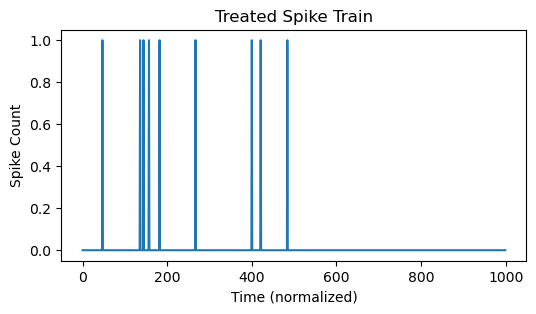

In [128]:
x_vals = np.array([i for i in range(1000)])
fig, ax = plt.subplots(figsize=(6, 3), frameon=False)
ax.plot(x_vals,ty[8,:], label='processed st')
ax.set_title('Treated Spike Train')
ax.set_xlabel('Time (normalized)')
ax.set_ylabel('Spike Count')
plt.show()

In [114]:
def split_data_one_LI(neuronDF, licksDF,LI):
    #this fctn takes dataframes and splits off the first 5 lI of data, writes in np arrray. 
    #LI needs to be from 1-5.
    yvals = np.zeros(shape=(len(licksDF),200))
    for row in range(len(licksDF)):
        y = np.zeros(200)
        
        l = np.array(licksDF.iloc[row, 4:]).astype(int)
        ltimes = np.nonzero(l)
        
        nfires = np.array(neuronDF.iloc[row, 4:]).astype(float)
        
        nfires = nfires[ltimes[0][LI-1]:ltimes[0][LI]]
        li_len = ltimes[0][LI] - ltimes[0][LI-1]
        print(li_len)
        
        if sum(nfires) != 0.0:
        #tspikes tells you times of where spikes should fall
            n=np.nonzero(nfires)
            #print(n)
            tspikes = np.array([nf/li_len for nf in n])
            #(np.nonzero(nfires)/(li_len)) #+ li
            #print(tspikes)
            tspikes = ((np.round(tspikes, decimals=3))*200).astype(int)
        
            for i in tspikes[0]:
                if 0 <= i < 200:
                    y[i] = 1.0
        
            yvals[row,:] = y
    
    return yvals


tn=neuronDF[(neuronDF['Taste'].isin([3])) & (neuronDF['Neuron'] == 380)]
tl=LickDF[(LickDF['Taste'].isin([3])) & (LickDF['Neuron'] == 380)]
ty=split_data_one_LI(tn,tl, 1)
ty

168
160
150
169
157
143
150
152
140
154
144
154
144
143
145
153
135
144
152
148
150
142
149


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

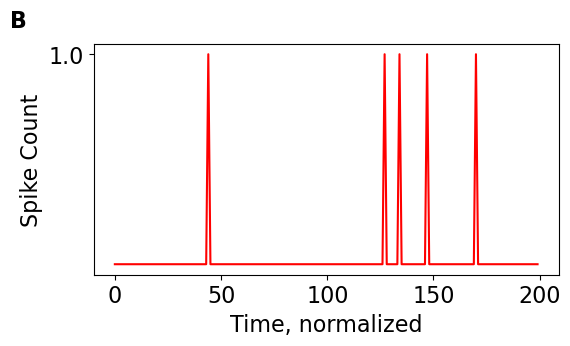

In [124]:
x_vals = np.array([i for i in range(200)])
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_vals,ty[8], c='red')
ax.text(-0.18, 1.15, 'B', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Time, normalized', fontsize=16)
ax.set_ylabel('Spike Count',fontsize=16)

ax.set_yticks([1.0])
ax.set_yticklabels([1.0], fontsize=16)

plt.show()

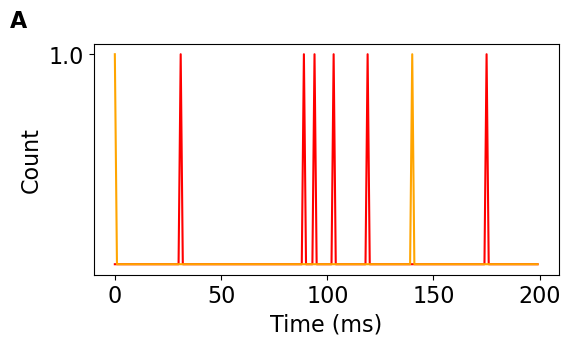

In [125]:
x_vals = np.array([i for i in range(200)])
fig, ax = plt.subplots(figsize=(6, 3))
#ax.plot(x_vals,ty[8], c='darkcyan')
ax.plot(x_vals,tn.iloc[8,4:204], c='red', label='raw st')
ax.plot(x_vals,tl.iloc[8,4:204], c='orange', label = 'licks')
ax.text(-0.18, 1.15, 'A', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Time (ms)',fontsize=16)
ax.set_ylabel('Count',fontsize=16)

ax.set_yticks([1.0])
ax.set_yticklabels([1.0], fontsize=16)

plt.show()

In [45]:
np.nonzero(tl.iloc[8,4:204])

(array([  0, 140], dtype=int64),)

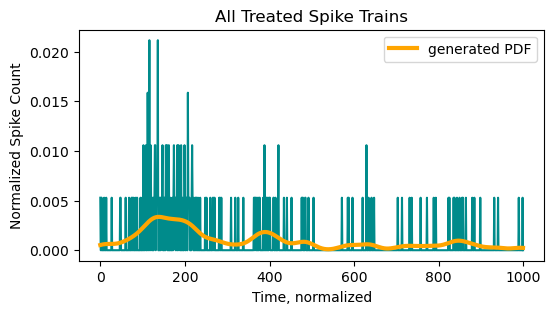

In [48]:
x_vals = np.array([i for i in range(1000)])
fig, ax = plt.subplots(figsize=(6, 3), frameon=False)
ax.plot(x_vals,np.sum(ty, axis = 0)/np.sum(np.sum(ty,axis=0)), c='darkcyan')
ax.plot(x_vals,phase_score_save[7,3], c='orange', lw=3, label='generated PDF')
ax.set_title('All Treated Spike Trains')
ax.set_xlabel('Time, normalized')
ax.set_ylabel('Normalized Spike Count')
ax.legend(loc='upper right')
plt.show()


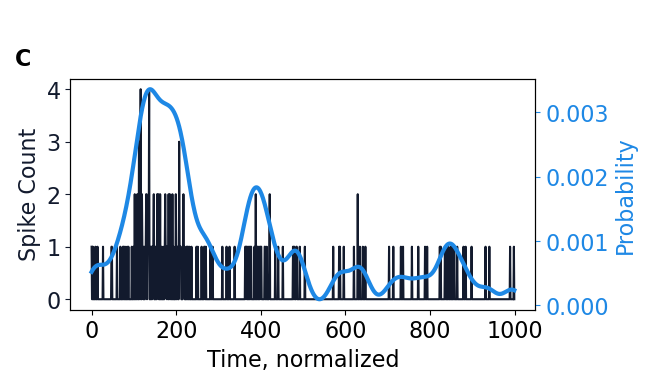

In [129]:
x_vals = np.array([i for i in range(1000)])
# Create the first plot
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.text(-0.13, 1.3, 'C', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# Plot the first data on the first Axes
ax1.plot(x_vals,np.sum(ty, axis = 0), c='#121A2D')
#ax1.plot(x_vals,np.sum(ty, axis = 0)/np.sum(np.sum(ty,axis=0)), c='#121A2D')
ax1.set_xlabel('Time, normalized',fontsize=16)
ax1.set_ylabel('Spike Count', color='#121A2D',fontsize=16)
ax1.tick_params('y', colors='#121A2D', labelsize=16)

# Create the second plot sharing the x-axis
ax2 = ax1.twinx()

# Plot the second data on the second Axes
ax2.plot(x_vals,phase_score_save[7,3], c='#1E88E5', lw=3, label='generated PDF')
ax2.set_ylabel('Probability', fontsize=16, color='#1E88E5')
ax2.tick_params('y', labelsize=16, colors='#1E88E5')

ax1.tick_params(axis='x', labelsize=16)

# Show the plots
plt.show()

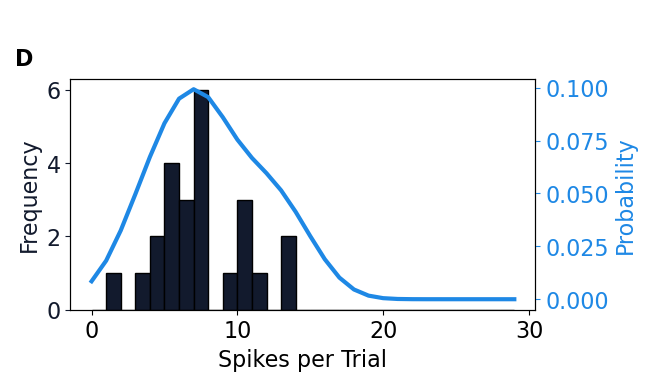

In [130]:
bin_width = 1
bin_range = np.arange(0, 30, bin_width)

#plt.hist(rate_per_trial[0], bins=bin_range, edgecolor='black')
#plt.show()
x_vals = np.array([i for i in range(30)])

# Create the first plot
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.text(-0.13, 1.3, 'D', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# Plot the first data on the first Axes
ax1.hist(rate_per_trial[35], bins=bin_range, color='#121A2D', edgecolor='black')
ax1.set_xlabel('Spikes per Trial', fontsize=16)
ax1.set_ylabel('Frequency',fontsize=16, color='#121A2D')
ax1.tick_params('y', labelsize=16, colors='#121A2D')

# Create the second plot sharing the x-axis
ax2 = ax1.twinx()

# Plot the second data on the second Axes
ax2.plot(x_vals,rate_score_save[7][3][0:30], c='#1E88E5', lw=3, label='generated PDF')
ax2.set_ylabel('Probability',fontsize=16, color='#1E88E5')
ax2.tick_params('y', labelsize=16, colors='#1E88E5')
ax1.tick_params(axis='x', labelsize=16)
# Show the plots
plt.show()

In [106]:
len(rate_per_trial)

60

In [79]:
coding_neurons


[0.0,
 28.0,
 44.0,
 314.0,
 315.0,
 354.0,
 355.0,
 380.0,
 520.0,
 522.0,
 523.0,
 525.0]

In [46]:
rate_per_trial[7]

array([1., 1., 2., 3., 3., 3., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       6., 6., 6., 7., 8.])

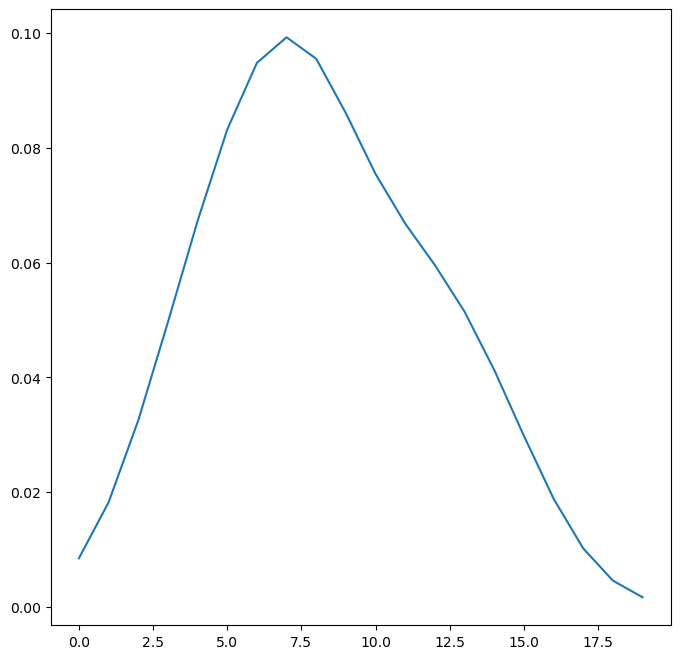

In [89]:
plt.plot(rate_score_save[7,3][0:20])
plt.show()

In [131]:
spike_data = tn.iloc[:,4:].to_numpy()
spike_data.shape

(23, 2001)

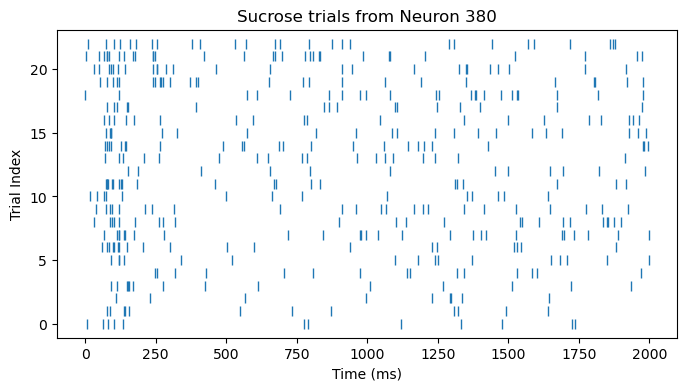

In [132]:


# Create a raster plot
def plot_raster(spike_data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,4),frameon=False)

    # Extract the indices (neuron, time) where spikes occurred
    neuron_indices, time_indices = np.where(spike_data)

    # Plot spikes as dots in the raster plot
    ax.plot(time_indices, neuron_indices, '|', markersize=7)
    # Set labels and title
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Trial Index')
    ax.set_title('Sucrose trials from Neuron 380')

# Plot the raster plot
plot_raster(spike_data)
plt.show()


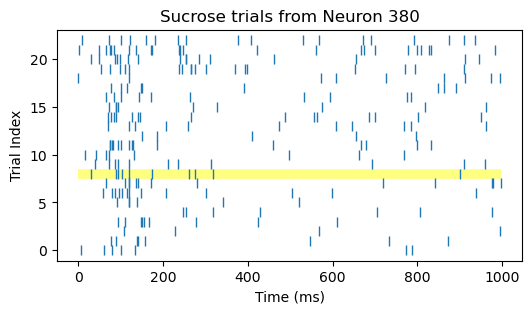

In [164]:
spike_data = tn.iloc[:,4:1005].to_numpy()
import matplotlib.patches as patches
def plot_raster_highlight_row_with_box(spike_data, highlight_row, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3), frameon=False)  # Adjust figsize for a more rectangular plot

    # Extract the indices (neuron, time) where spikes occurred
    neuron_indices, time_indices = np.where(spike_data)

    # Plot spikes as dots in the raster plot
    ax.plot(time_indices, neuron_indices, '|', markersize=7)

    # Highlight the specified row with a yellow semi-transparent box
    row_indices = np.where(neuron_indices == highlight_row)[0]
    ax.add_patch(patches.Rectangle((min(time_indices), min(neuron_indices[row_indices])),
                                   max(time_indices) - min(time_indices),
                                   max(neuron_indices[row_indices]) - min(neuron_indices[row_indices]),
                                   linewidth=7, edgecolor='yellow', facecolor='yellow', alpha=0.5))

    # Set labels and title
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Trial Index')
    ax.set_title('Sucrose trials from Neuron 380')

    # Set aspect ratio to be equal for a more compact plot
    ax.set_aspect('auto')

# Specify the row to highlight (e.g., the first row)
highlighted_row = 8

# Plot the raster plot with a more rectangular layout, no bounding box, and highlighted row with a box
plot_raster_highlight_row_with_box(spike_data, highlighted_row)
plt.savefig('neuron380highlightSHORT.png',bbox_inches='tight')
plt.show()


In [126]:
tn.iloc[0:10,0:1004]

,Recording Type,Taste,Neuron,Trial,0,1,2,3,4,5,...,990,991,992,993,994,995,996,997,998,999
82586,Neuron,3,380,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82588,Neuron,3,380,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82590,Neuron,3,380,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
82592,Neuron,3,380,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82594,Neuron,3,380,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82596,Neuron,3,380,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82598,Neuron,3,380,6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82600,Neuron,3,380,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
82602,Neuron,3,380,8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82604,Neuron,3,380,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
phase_score_save = []

In [12]:
x_vals = np.tile(np.arange(1000), 5).reshape(5,1000)[:,np.newaxis]
for neuron_ID in coding_neurons:
    neuron_tp_df = neuronDF[(neuronDF['Neuron'] == neuron_ID)]
    lick_tp_df = LickDF[(LickDF['Neuron'] == neuron_ID)]
    kde_scores = prep_phase(20, neuron_tp_df, lick_tp_df)
    phase_score_save.append(kde_scores)
    d = wfr_r1(delta, kde_scores, x_vals, max_steps, eps).numpy()
    ls_d_p.append(d)
    #plt.matshow((d/d.max()))
    #plt.clim(0.00005,0.00)
    #plt.colorbar()
    #plt.show
dist_mat = np.array(ls_d_p)

<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>


In [13]:
ls_d_p

[array([[0.        , 0.02091579, 0.0255323 , 0.02310384, 0.03264166],
        [0.02091579, 0.        , 0.01933379, 0.01615391, 0.02820485],
        [0.0255323 , 0.01933379, 0.        , 0.022095  , 0.03328454],
        [0.02310384, 0.01615391, 0.022095  , 0.        , 0.02965624],
        [0.03264166, 0.02820485, 0.03328454, 0.02965624, 0.        ]],
       dtype=float32),
 array([[0.        , 0.04224813, 0.0362624 , 0.03903769, 0.03857159],
        [0.04224813, 0.        , 0.0348838 , 0.03749439, 0.03704804],
        [0.0362624 , 0.0348838 , 0.        , 0.03108193, 0.03033274],
        [0.03903769, 0.03749439, 0.03108193, 0.        , 0.03329426],
        [0.03857159, 0.03704804, 0.03033274, 0.03329426, 0.        ]],
       dtype=float32),
 array([[0.        , 0.04293732, 0.03254473, 0.04185511, 0.0356775 ],
        [0.04293732, 0.        , 0.03048167, 0.0400181 , 0.03383657],
        [0.03254473, 0.03048167, 0.        , 0.02893782, 0.01885632],
        [0.04185511, 0.0400181 , 0.0289378

In [14]:
coding_neurons[0:8]

[0.0, 28.0, 44.0, 314.0, 315.0, 354.0, 355.0, 380.0]

In [15]:
rate_score_save = []

<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>


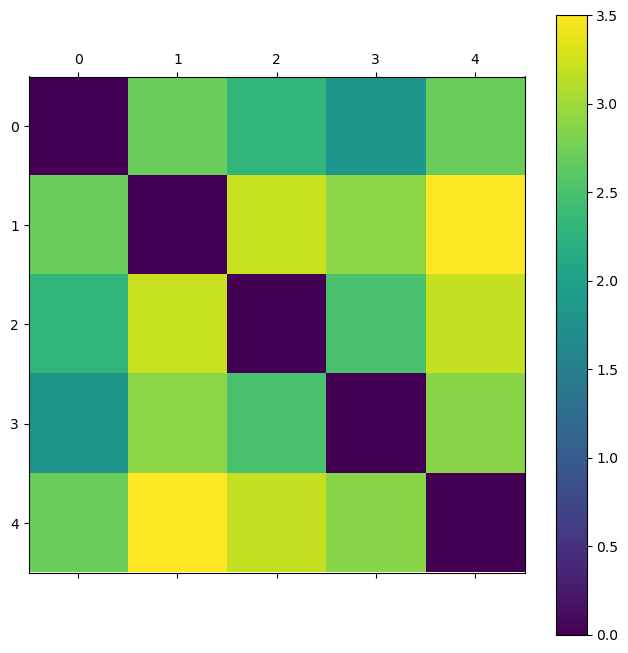

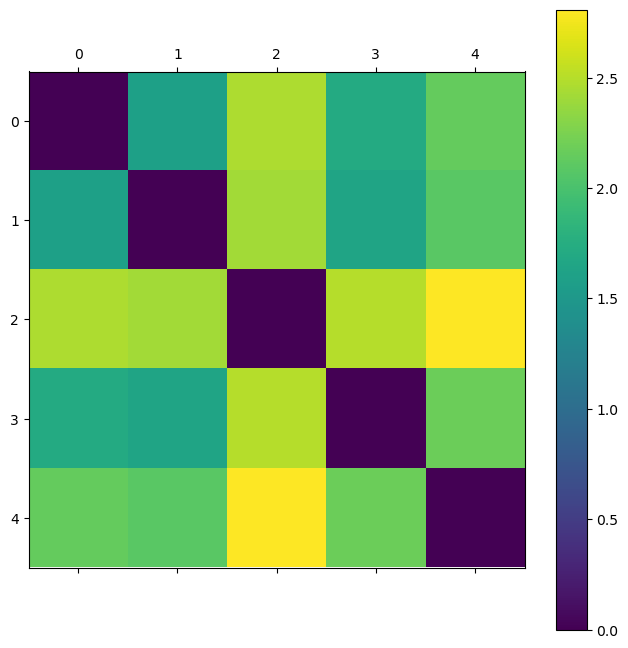

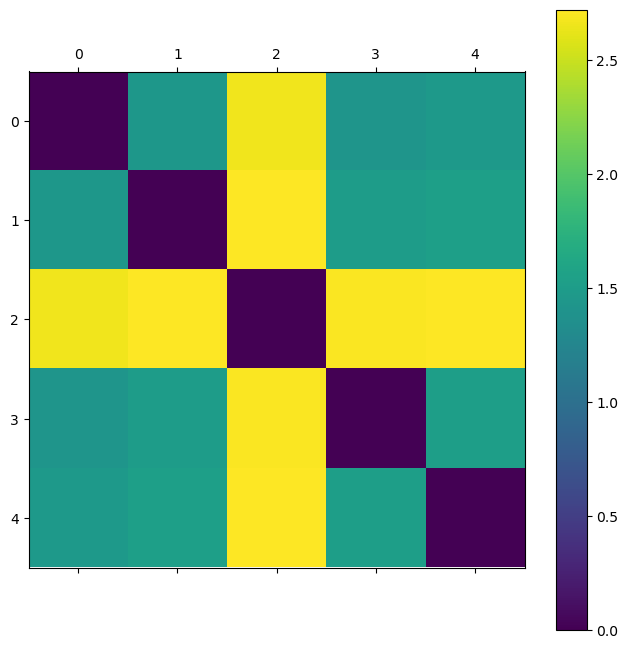

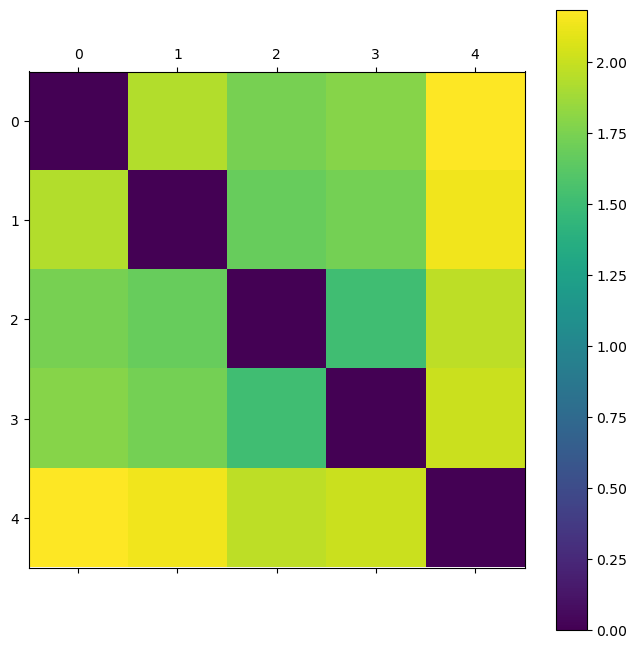

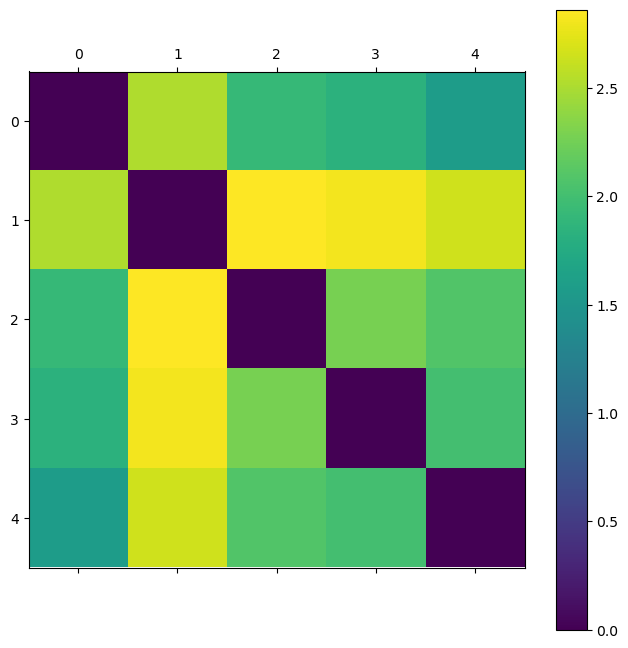

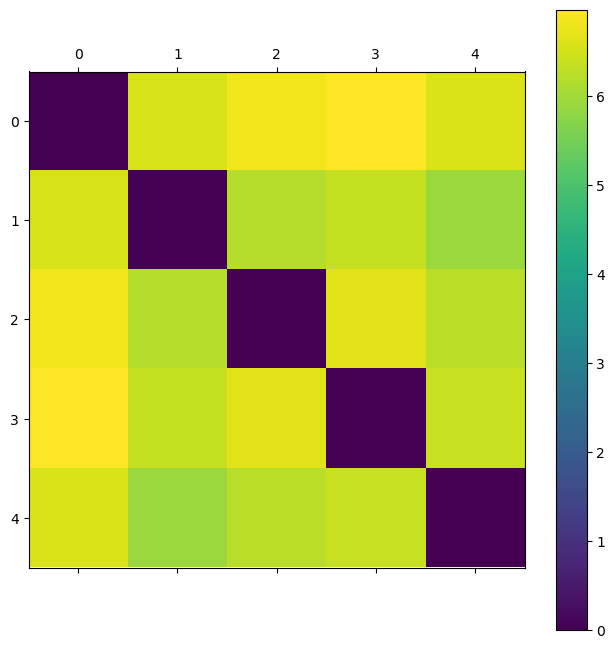

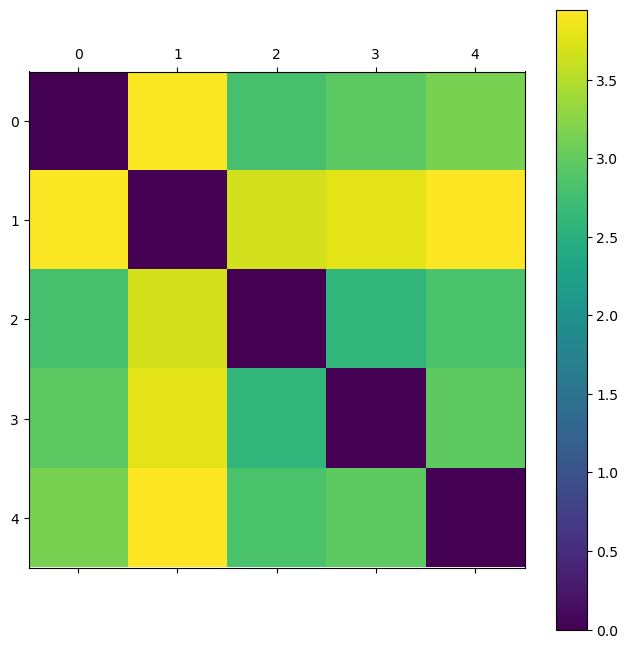

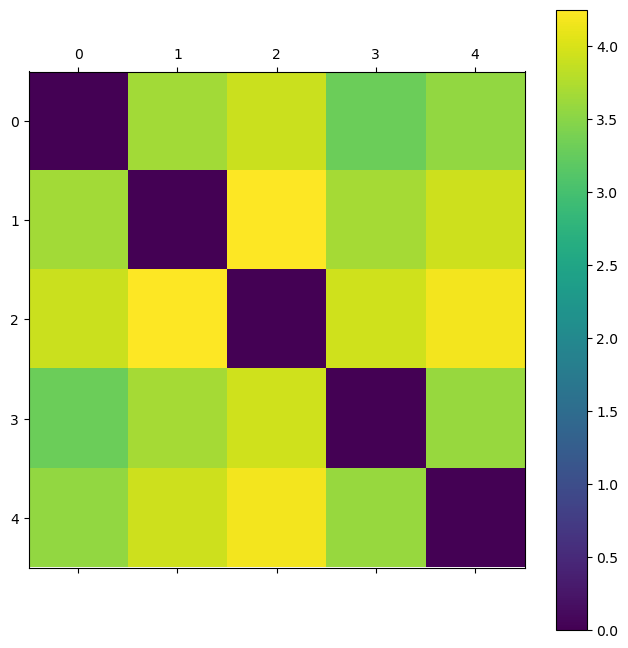

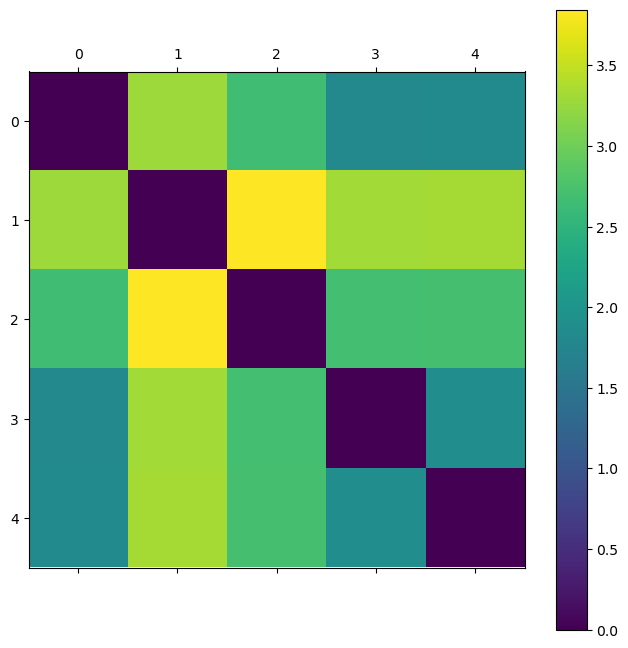

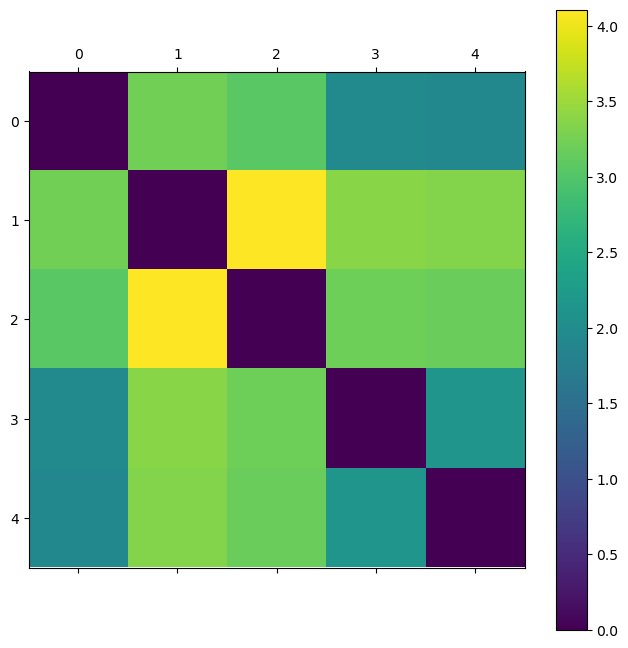

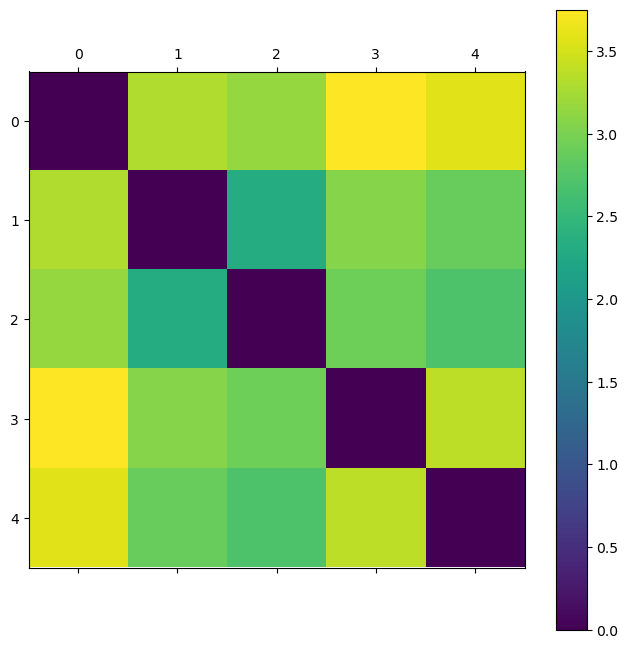

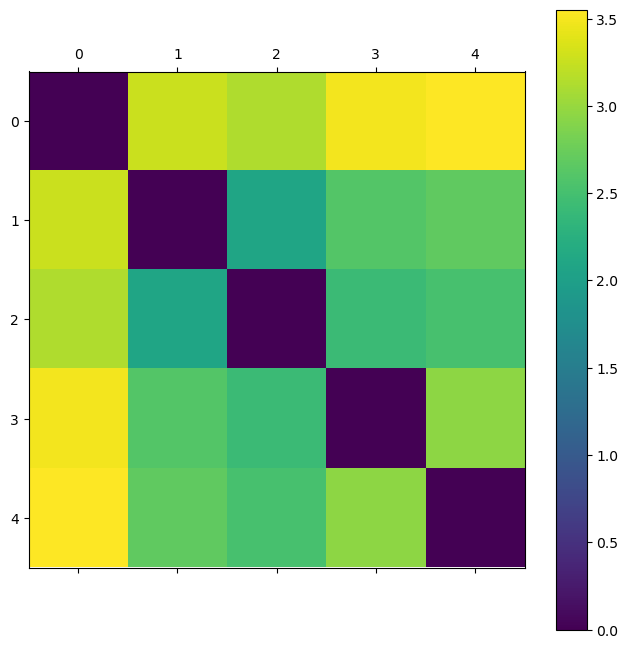

In [16]:
x_vals = np.array([i for i in range(1000)])[:,np.newaxis]
x_vals_5tastes = np.tile(np.arange(1000), 5).reshape(5,1000)[:,np.newaxis]
rate_per_trial = []
for neuron_ID in coding_neurons:
    neuron_df = neuronDF[(neuronDF['Neuron'] == neuron_ID)]
    lick_tp_df = LickDF[(LickDF['Neuron'] == neuron_ID)]

    kde_xvals =[]
    kde_scores = []
    

    for taste in post_stim['Taste'].unique():
        tn=neuron_df[(neuron_df['Taste'].isin([taste]))]
            #post_stim[(post_stim['Recording Type'] == 'Neuron') & (post_stim['Taste'].isin([taste]))]
        tl=lick_tp_df[(lick_tp_df['Taste'].isin([taste]))]
            #post_stim[(post_stim['Recording Type'] == 'Lick') & (post_stim['Taste'].isin([taste]))]

        ty=split_data_Li(tn,tl)
        
        vals = np.sum(ty, axis=1)
        vals.sort()
        rate_per_trial.append(vals)
        kde_input = vals[:, np.newaxis]

        kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(kde_input)
        scores = kde.score_samples(x_vals)
        
        kde_scores.append(np.exp(scores))
    scores=np.array(kde_scores)
    rate_score_save.append(scores)
    dr = wfr_r1(delta, scores, x_vals_5tastes, max_steps, eps).numpy()
    ls_d_r.append(dr)
    plt.matshow(dr*100)
    plt.colorbar()
    plt.show

In [17]:
dist_mat_r = np.array(ls_d_r)

In [18]:
#can we plot those rate and phase distributions for neuron 354 (element 5 in coding neurons?)
# why is it seperate from everyone else in the mds plots for rate and phase

phase_score_save = np.array(phase_score_save)
rate_score_save = np.array(rate_score_save)

In [19]:
rate_score_save.shape

(12, 5, 1000)

In [21]:
coding_neurons[4]

315.0

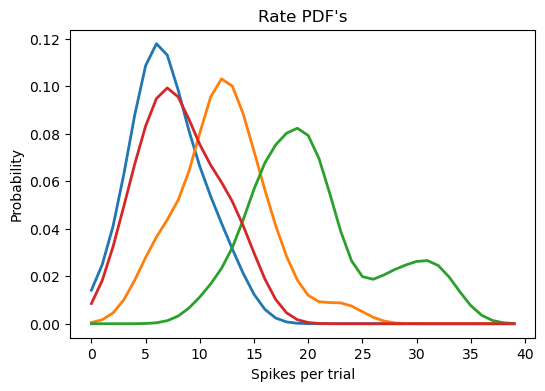

In [22]:
x_vals = np.array([i for i in range(40)])
plt.figure(figsize=(6,4))
plt.plot(x_vals, rate_score_save[7,0, :40],linewidth=2, label = 'taste 0')
plt.plot(x_vals, rate_score_save[7,1, :40],linewidth=2, label = 'taste 1')
plt.plot(x_vals, rate_score_save[7,2, :40],linewidth=2, label = 'taste 2')
plt.plot(x_vals, rate_score_save[7,3, :40],linewidth=2, label = 'taste 3')
#plt.plot(x_vals, rate_score_save[7,4, :40],linewidth=2, label = 'taste 4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.legend(loc='upper right')
plt.xlabel('Spikes per trial')
plt.ylabel('Probability')
#plt.text(-1.0, 0.175, 'B', style='normal',fontsize=24)
plt.title("Rate PDF's")
plt.show()

In [23]:
coding_neurons[7]

380.0

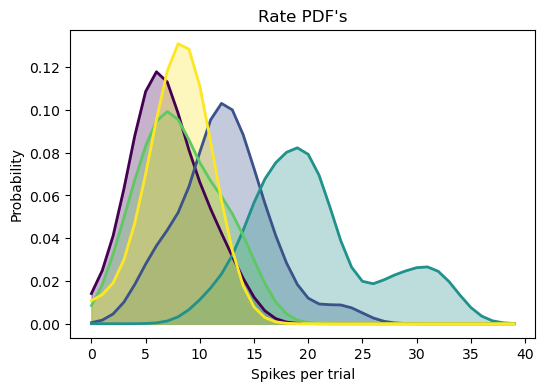

In [140]:
# Plot the lines and shade the area underneath
plt.figure(figsize=(6,4))
for i in range(5):
    line_color = plt.cm.viridis(i / 4.0)  # Use a colormap for varying colors
    plt.plot(x_vals, rate_score_save[7, i, :40], linewidth=2, label=f'taste {i}', color=line_color)
    plt.fill_between(x_vals, rate_score_save[7, i, :40], color=line_color, alpha=0.3)

# Customize the plot
plt.xlabel('Spikes per trial')
plt.ylabel('Probability')
plt.title("Rate PDF's")
#plt.legend()

# Show the plot
plt.show()

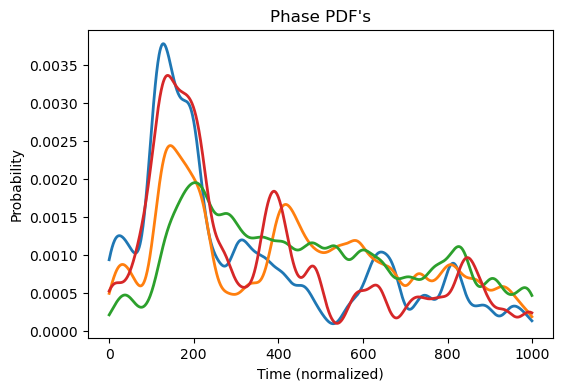

In [24]:
x_vals = np.array([i for i in range(1000)])
plt.figure(figsize=(6,4))
plt.plot(x_vals, phase_score_save[7,0],linewidth=2, label = 'taste 0')
plt.plot(x_vals, phase_score_save[7,1],linewidth=2, label = 'taste 1')
plt.plot(x_vals, phase_score_save[7,2],linewidth=2, label = 'taste 2')
plt.plot(x_vals, phase_score_save[7,3],linewidth=2, label = 'taste 3')
#plt.plot(x_vals, phase_score_save[7,4],linewidth=2, label = 'taste 4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.legend(loc='upper right')
plt.xlabel('Time (normalized)')
plt.ylabel('Probability')
#plt.text(0, 0.00375, 'A', style='normal',fontsize=24)
plt.title("Phase PDF's")
plt.show()

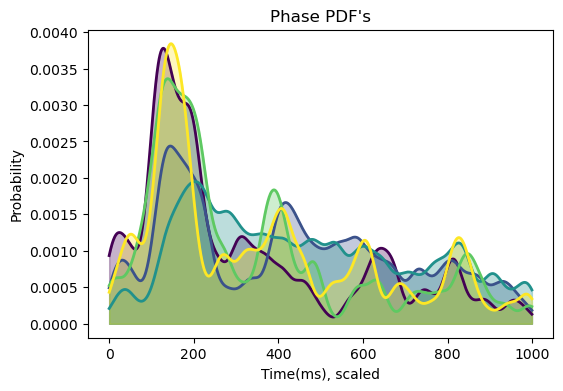

In [142]:
# Plot the lines and shade the area underneath
plt.figure(figsize=(6,4))
for i in range(5):
    line_color = plt.cm.viridis(i / 4.0)  # Use a colormap for varying colors
    plt.plot(x_vals, phase_score_save[7, i], linewidth=2, label=f'taste {i}', color=line_color)
    plt.fill_between(x_vals, phase_score_save[7, i], color=line_color, alpha=0.3)

# Customize the plot
plt.xlabel('Time(ms), scaled')
plt.ylabel('Probability')
plt.title("Phase PDF's")
#plt.legend()

# Show the plot
plt.show()

## Visualize the Phase data:

Create distinguish, a matrix with entries 1 or 0, depending on the threshold mean+std. This tells us if the neuron can distinguish between the tastes in this taste pair.

In [16]:
#fill in distinguish: if the entry for dist between these two tastes is bigger than mean+ std, gets a 1.
#fill node size:
distinguish = np.zeros(shape =(len(coding_neurons),5,5))
node_size = []
for coding_neuron in range(len(dist_mat)):
    for taste1 in range(5): #row of taste matrix
        for taste2 in range(5): #column of taste matrix
            thresh = np.mean(dist_mat[:,taste1,taste2])+np.std(dist_mat[:,taste1,taste2])
            if (dist_mat[coding_neuron,taste1,taste2] > thresh):
                distinguish[coding_neuron,taste1,taste2] = 1
            else:
                distinguish[coding_neuron,taste1,taste2] = 0
    node_size.append(np.sum(distinguish[coding_neuron])/2)

In [17]:
#node labels is coding_neurons. 
#node size is given by np.sum(distinguish[node])/2 
#edge if two neurons can distinguish the same (if distinguish[coding_neuron,taste1,taste2] is the same, count. divide by 2.)
#edge weight is given by the count above.

nodes = [i for i in range(len(dist_mat))]
nodes_labels_nodesize = list(zip(nodes, coding_neurons, node_size))

In [18]:
len(distinguish[0][0])

5

Create a weighted adjacency matrix for the graph and make it available for export.

In [19]:
#lets make weighted edges
weighted_adj = np.zeros(shape = (len(distinguish),len(distinguish)))
for row in range(len(distinguish)):
    for column in range(len(distinguish)):
        if (row != column):
            weighted_adj[row,column] = edgeweight_finder(row,column,distinguish)
        else:
            weighted_adj[row,column] = 0.

In [20]:
node_size_dict = {nodes[i]: node_size[i].astype(int) for i in range(len(nodes))}
relabel_dict = {nodes[i]: coding_neurons[i] for i in range(len(nodes))}
#res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

In [21]:
G = nx.from_numpy_array(weighted_adj, parallel_edges=False)
nx.set_node_attributes(G, node_size_dict, name="size")
H = nx.relabel_nodes(G, relabel_dict)

In [22]:
nx.write_gexf(H,"phase_only_edges.gexf")

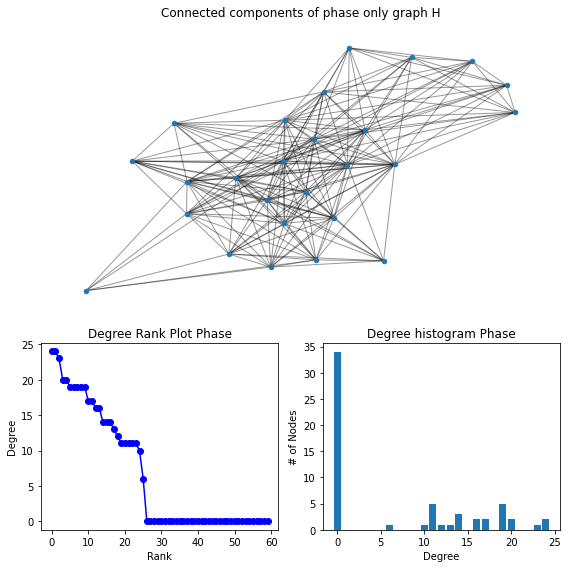

In [23]:
degree_sequence = sorted((d for n, d in H.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Hcc = H.subgraph(sorted(nx.connected_components(H), key=len, reverse=True)[0])
pos = nx.spring_layout(Hcc, seed=10396953)
nx.draw_networkx_nodes(Hcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Hcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of phase only graph H")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot Phase")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram Phase")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

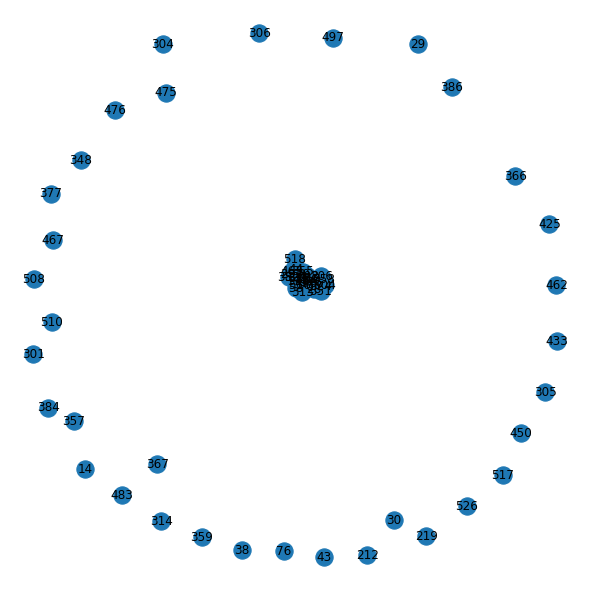

In [24]:
nx.draw(H, with_labels = True)
plt.show()

## Phase MDS:

In [346]:
coding_neurons

[0.0,
 28.0,
 44.0,
 314.0,
 315.0,
 354.0,
 355.0,
 380.0,
 520.0,
 522.0,
 523.0,
 525.0]

In [23]:
dist_sum = np.sum(mds_inputp, axis=1)

In [24]:
dist_sum

array([0.25092192, 0.30197031, 0.2184256 , 0.15947939, 0.06861083,
       0.26012025, 0.30412406, 0.66192353, 0.5219239 , 0.15265831,
       0.3231216 , 0.32587771, 0.14383864, 0.40239085, 0.15415992,
       0.29572772, 0.567514  , 0.15157979, 0.16707622, 0.70236715,
       0.30818974, 0.18081371, 0.5602115 , 0.19309474, 0.22519318,
       0.14696229, 0.87232812, 0.33558493, 0.36025496, 0.13783785,
       0.0903246 , 0.28940215, 0.20375886, 0.23460938, 0.20495485,
       0.34673614, 0.18330675, 0.16122315, 0.24081701, 0.09379297,
       0.20012557, 0.23026292, 0.19451369, 0.28155794, 0.33759834,
       0.18725565, 0.23008472, 0.61310019, 0.15150989, 0.24568091,
       0.35007779, 0.23586255, 0.36674282, 0.24492042, 0.35755385,
       0.2163456 , 0.18829301, 0.19879331, 0.26260337, 0.4018028 ,
       0.1479085 , 0.30772278, 0.50019204, 0.71293555, 0.19415144,
       0.5672456 , 0.31059086, 0.22248201, 0.18127392, 0.42546594,
       0.15907207, 0.42762618, 0.11628783, 0.28296276, 0.31833

In [24]:
sorted_ba = np.sort(neuron_vs_score[:,1])[::-1]
sorted_ba.shape

(529,)

In [26]:
neuron_vs_score.shape

(529, 2)

In [25]:
dist_sum.shape

(529,)

In [45]:
a_to_sort = np.append(neuron_vs_score,np.array(dist_max)[:,np.newaxis], axis = 1)
a_to_sort.shape

(529, 3)

In [43]:
dist_max = [ls_d_p[i].max() for i in range(len(ls_d_p))]

In [44]:
dist_max

[0.033284537,
 0.033868488,
 0.024134943,
 0.017693484,
 0.008477631,
 0.029040834,
 0.033266447,
 0.08543154,
 0.061465267,
 0.03816458,
 0.03487329,
 0.039631072,
 0.016717821,
 0.050590508,
 0.016578503,
 0.03331799,
 0.081209086,
 0.017339427,
 0.01867226,
 0.10296555,
 0.03310253,
 0.023855828,
 0.06429927,
 0.020902593,
 0.026162917,
 0.016424399,
 0.1202091,
 0.044634268,
 0.04224813,
 0.0152363535,
 0.010891917,
 0.0352608,
 0.023180563,
 0.025322631,
 0.023892513,
 0.04093117,
 0.022423968,
 0.018518504,
 0.028148849,
 0.010210482,
 0.022849962,
 0.025264835,
 0.024349462,
 0.031718545,
 0.042937316,
 0.020744503,
 0.024633713,
 0.089329906,
 0.017296152,
 0.027190529,
 0.042449698,
 0.026164418,
 0.039576557,
 0.028789107,
 0.039116763,
 0.024321472,
 0.022309449,
 0.021804878,
 0.0358261,
 0.043922003,
 0.015648434,
 0.037050083,
 0.056743238,
 0.1008032,
 0.020403575,
 0.06570741,
 0.033553705,
 0.025963977,
 0.0195056,
 0.050847147,
 0.017214576,
 0.048278205,
 0.012480605

In [46]:
a_to_sort

array([[0.00000000e+00, 5.59420290e-01, 3.32845375e-02],
       [1.00000000e+00, 2.89855072e-01, 3.38684879e-02],
       [2.00000000e+00, 2.52173913e-01, 2.41349433e-02],
       ...,
       [5.26000000e+02, 2.60606061e-01, 3.04322448e-02],
       [5.27000000e+02, 2.39393939e-01, 3.18661071e-02],
       [5.28000000e+02, 1.93939394e-01, 2.21695863e-02]])

In [47]:

sorted_indices = np.argsort(a_to_sort[:, 1])[::-1]
sorted_array = a_to_sort[sorted_indices]
sorted_array.shape

(529, 3)

In [48]:
sorted_array

array([[5.22000000e+02, 5.90909091e-01, 2.71080360e-02],
       [3.54000000e+02, 5.72727273e-01, 6.26944890e-03],
       [0.00000000e+00, 5.59420290e-01, 3.32845375e-02],
       ...,
       [1.78000000e+02, 1.06666667e-01, 3.78155857e-02],
       [2.50000000e+02, 1.04166667e-01, 1.41790025e-02],
       [2.55000000e+02, 1.00000000e-01, 1.09119229e-02]])

[]

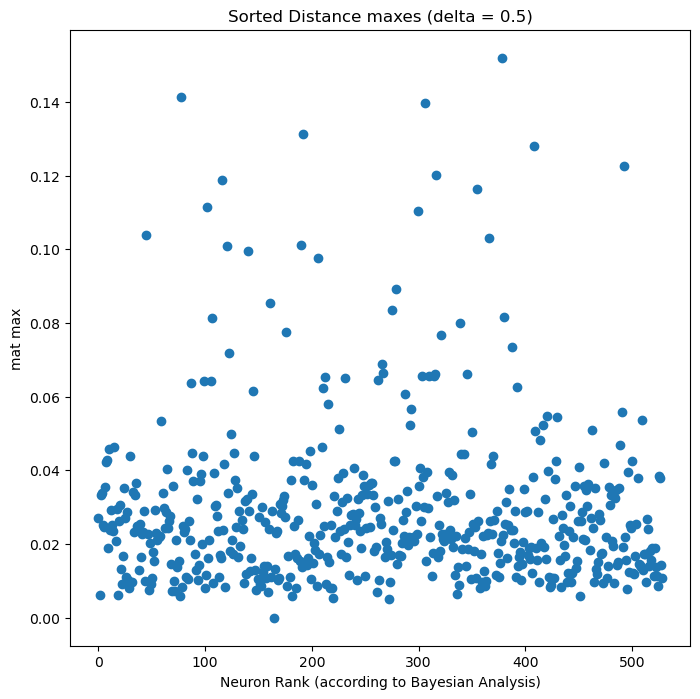

In [50]:
plt.scatter((range(len(sorted_array))),sorted_array[:,2])
plt.title('Sorted Distance maxes (delta = 0.5)')
#plt.axhline(y=np.mean(sorted_ba),color='green', label='Mean')
#plt.axhline(y=0.4,color='purple', label='Threshold')
#plt.axhline(y=(np.mean(sorted_ba) + abs(np.std(sorted_ba))),color='orange', label='Mean + STD')
#plt.axhline(y=0.2,color='red', label='Random Guessing')
plt.xlabel('Neuron Rank (according to Bayesian Analysis)')
plt.ylabel('mat max')
#plt.legend(loc = 'upper right')
plt.plot()

In [32]:
#phase
f_norm = [np.linalg.norm(ls_d_p[i], ord='fro') for i in range(len(ls_d_p))]

In [33]:
len(f_norm)

529

In [16]:
mds_inputp = np.zeros(shape=(len(coding_neurons),10))
counter = 0
for coding_neuron in range(len(dist_mat)):
    for row in range(0,len(dist_mat[0])-1):
        for column in range(row+1, len(dist_mat[0])):
            mds_inputp[coding_neuron,counter%10] = dist_mat[coding_neuron,row,column]
            counter = counter + 1

In [17]:
mds_inputp.shape

(529, 10)

In [18]:
embedding = MDS(n_components=2)
input_transformedp = embedding.fit_transform(mds_inputp[:len(coding_neurons)])
input_transformedp.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(529, 2)

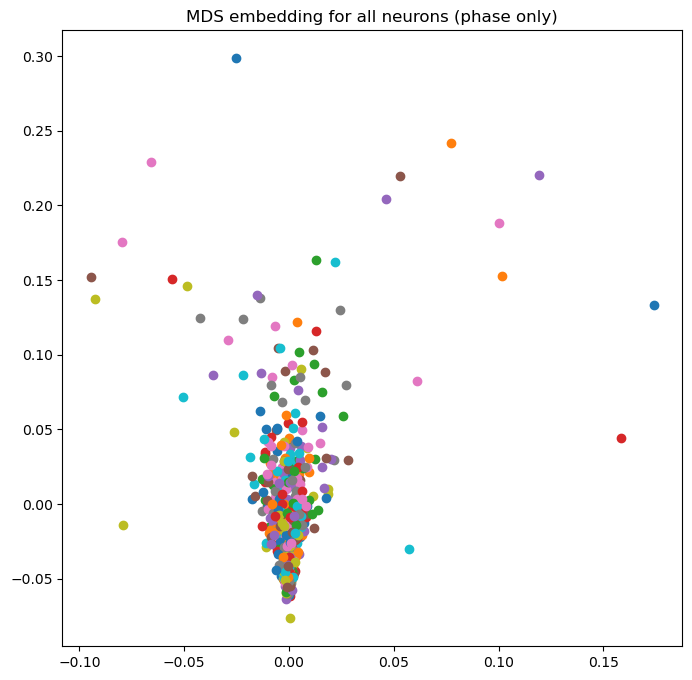

In [19]:
for i in range(len(input_transformedp)):
    plt.scatter(input_transformedp[i,0],input_transformedp[i,1], label=i)
    #label = f"({coding_neurons[i]})"
    #plt.annotate(label, (input_transformedp[i,0],input_transformedp[i,1]), textcoords="offset points", xytext=(0,5),
                 #ha='center')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('MDS embedding for all neurons (phase only)')
plt.show()

### PCA on phase data

In [234]:
from sklearn.decomposition import PCA

pca = PCA() # Initialize the model
pca.fit(mds_inputp) # fit the model to our data matrix

PCA()

In [235]:
pVec0 = pca.components_[0]
pVec1 = pca.components_[1]

projectedphase = []

# Now we linearly project every sample in our dataset onto the two-dimensional subspace spanned by the first 
# two singular vectors
for j in range(len(coding_neurons)):
    projectedphase.append([np.dot(mds_inputp[j],pVec0),np.dot(mds_inputp[j],pVec1)])

projectedphase = np.array(projectedphase)

(0.00010684410603175893,
 0.002455622363633849,
 1.3262195604095464e-05,
 0.00011958620540102277)

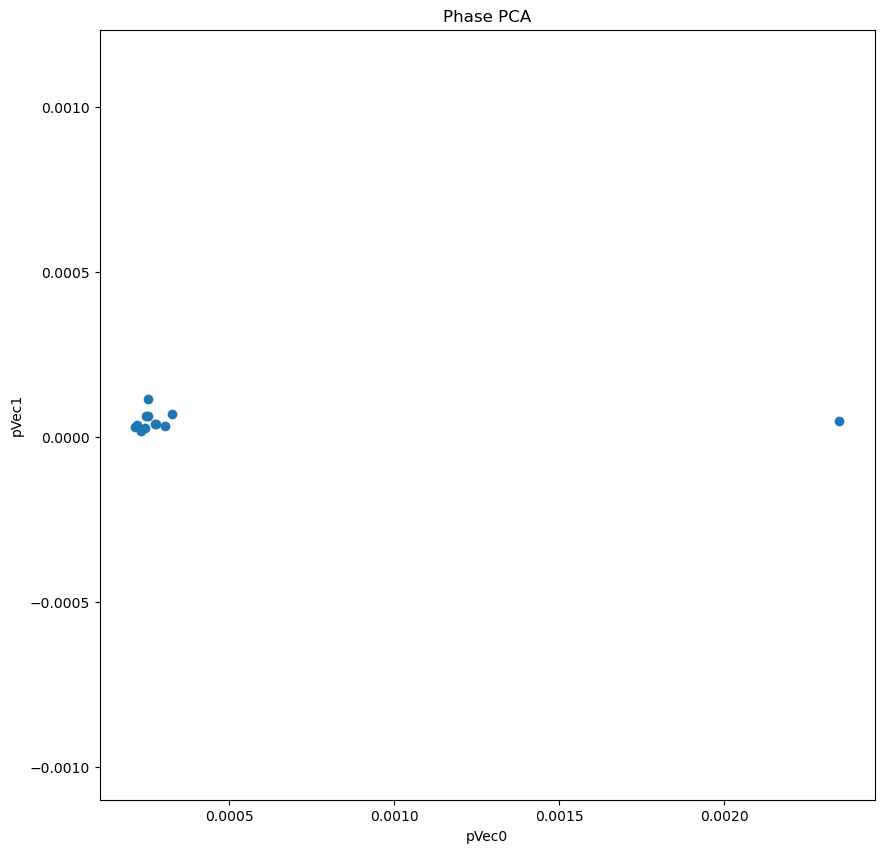

In [236]:
plt.figure(figsize=(10,10))

plt.scatter(projectedphase[:, 0], projectedphase[:, 1])

plt.title('Phase PCA')
plt.xlabel('pVec0')
plt.ylabel('pVec1')
plt.axis('equal')

Create a hypernetwork to visualize the data. Here, we only include points that /do/ distinguish 1+ tastes. This more easily shows which taste pairs two neurons share.

In [32]:
#hypernetx from same data:
#want a dict tastepairs = {01: (distinguish[:,0,1] == 1), 02: (), 03: (), 04:(), 12:(), 13:(), 14:(), 23:(), 24:(), 34:()}

#maybe make array into a pands df and then can rename columns and rows by the dict.
hyperedge_dict = {}
#iterate here over upper triangle - diag in each coding neuron matrix
for row in range(0, len(distinguish[0])-1):
    for column in range(row+1, len(distinguish[0])):
        #print(row,column)
        key = row, column
        ls = distinguish[:,row,column] == 1.
        n = [i for i, x in enumerate(ls) if x]
        #maybe change n values here by dictionary relabel_dict?
        hyperedge_dict[key] = n

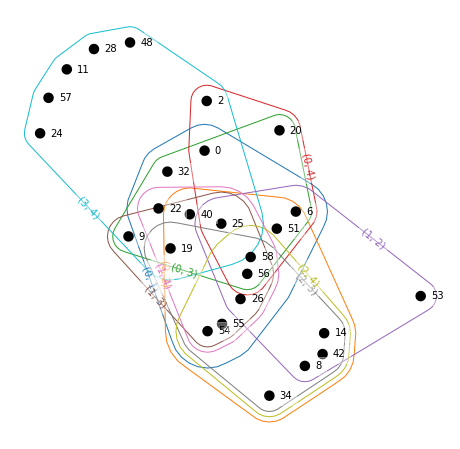

In [33]:
Hypernet = hnx.Hypergraph(hyperedge_dict)
hnx.draw(Hypernet)

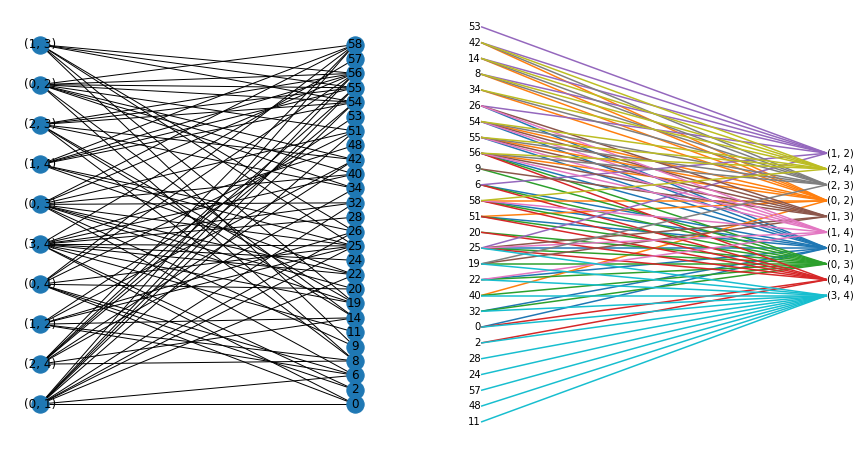

In [34]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
BH = Hypernet.bipartite()
top = nx.bipartite.sets(BH)[0]
pos = nx.bipartite_layout(BH, top)
nx.draw(BH, with_labels=True,pos=pos,ax=ax[0])
hnx.drawing.two_column.draw(Hypernet,ax=ax[1])

here: also create the dual hypergraph. also visualizes only the neurons that distinguish at least one taste pair, and now neurons are hyperedges and the nodes are taste pairs.

In [35]:
hyper_back = {}
messy_edges = []


edge_names = [i for i in range(10)]
edge_values = []
for row in range(0, len(distinguish[0])-1):
    for column in range(row+1, len(distinguish[0])):
        edge_values.append((row, column))

keylist = [i for i in range(len(distinguish))]
for key in keylist:
    ls = []
    for edge in edge_names:
        if distinguish[key][edge_values[edge][0]][edge_values[edge][1]] == 1:
            item = (edge_values[edge][0], edge_values[edge][1])
            ls.append(item)
    if ls:
    #    item = (0,0)
    #    ls.append(item)
        hyper_back[key] = ls
    
#convert this dict back to list, delete all list element where second element (list)is empty
#then convert back to a dictionary?

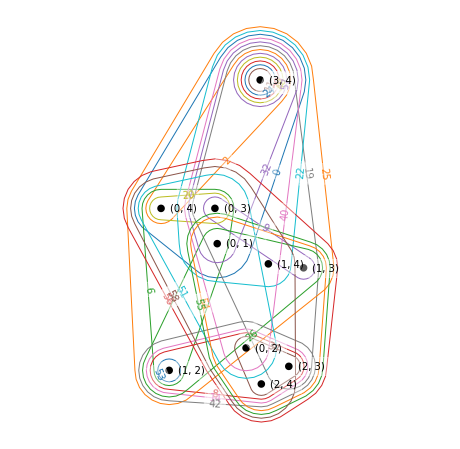

In [36]:
backHypernet = hnx.Hypergraph(hyper_back)
hnx.draw(backHypernet)

create hierarchical clustering from a phase hypergraph's information. Once visualized, we can compare the phase and rate hypergraphs more easily. 

In [37]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
def Union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list
def JaccardSim(lst1, lst2):
    similarity = len(intersection(lst1,lst2))/len(Union(lst1,lst2))
    return similarity

def dict_to_simMat(dictionary):
    dict_list = list(dictionary.items())
    simMat = np.ones(shape = (len(dict_list),len(dict_list)))
    for row in range(len(dict_list)):
        for col in range(len(dict_list)):
            simMat[row,col] = 1 - JaccardSim(dict_list[row][1],dict_list[col][1])
    return simMat

def plot_dendrogram(model, leaflabels, **kwargs):
    #from sklearn example
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,labels = leaflabels, **kwargs)

In [38]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [73]:
PhaseSimMat

array([[0.        , 0.6875    , 0.53333333, 0.53846154, 0.8       ,
        0.61538462, 0.36363636, 0.8125    , 0.73333333, 0.78947368],
       [0.6875    , 0.        , 0.76470588, 0.8       , 0.78571429,
        0.78571429, 0.69230769, 0.36363636, 0.2       , 0.95238095],
       [0.53333333, 0.76470588, 0.        , 0.53846154, 0.875     ,
        0.71428571, 0.71428571, 0.88235294, 0.88235294, 0.72222222],
       [0.53846154, 0.8       , 0.53846154, 0.        , 0.84615385,
        0.84615385, 0.75      , 0.93333333, 0.85714286, 0.82352941],
       [0.8       , 0.78571429, 0.875     , 0.84615385, 0.        ,
        0.83333333, 0.83333333, 0.75      , 0.75      , 0.94444444],
       [0.61538462, 0.78571429, 0.71428571, 0.84615385, 0.83333333,
        0.        , 0.44444444, 0.63636364, 0.75      , 0.88235294],
       [0.36363636, 0.69230769, 0.71428571, 0.75      , 0.83333333,
        0.44444444, 0.        , 0.75      , 0.63636364, 0.88235294],
       [0.8125    , 0.36363636, 0.8823529

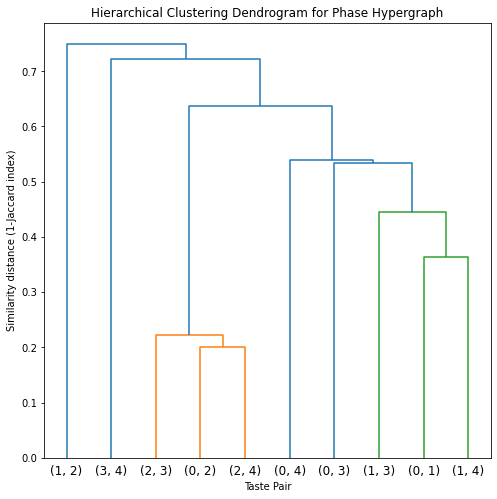

In [39]:
PhaseSimMat = dict_to_simMat(hyperedge_dict)
X = [i for i in range(10)]
new_labels = list(hyperedge_dict.keys())

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity = 'precomputed', linkage = 'single')

model = model.fit(PhaseSimMat)
plt.title("Hierarchical Clustering Dendrogram for Phase Hypergraph")
# plot the top three levels of the dendrogram
plot_dendrogram(model, new_labels)
plt.ylabel("Similarity distance (1-Jaccard index)")
plt.xlabel("Taste Pair")
#plt.xticks(X,new_labels)
plt.show()

In [40]:
PhaseSimMat

array([[0.        , 0.6875    , 0.53333333, 0.53846154, 0.8       ,
        0.61538462, 0.36363636, 0.8125    , 0.73333333, 0.78947368],
       [0.6875    , 0.        , 0.76470588, 0.8       , 0.78571429,
        0.78571429, 0.69230769, 0.36363636, 0.2       , 0.95238095],
       [0.53333333, 0.76470588, 0.        , 0.53846154, 0.875     ,
        0.71428571, 0.71428571, 0.88235294, 0.88235294, 0.72222222],
       [0.53846154, 0.8       , 0.53846154, 0.        , 0.84615385,
        0.84615385, 0.75      , 0.93333333, 0.85714286, 0.82352941],
       [0.8       , 0.78571429, 0.875     , 0.84615385, 0.        ,
        0.83333333, 0.83333333, 0.75      , 0.75      , 0.94444444],
       [0.61538462, 0.78571429, 0.71428571, 0.84615385, 0.83333333,
        0.        , 0.44444444, 0.63636364, 0.75      , 0.88235294],
       [0.36363636, 0.69230769, 0.71428571, 0.75      , 0.83333333,
        0.44444444, 0.        , 0.75      , 0.63636364, 0.88235294],
       [0.8125    , 0.36363636, 0.8823529

In [41]:
neuronComps = [coding_neurons[8],coding_neurons[12],coding_neurons[24],coding_neurons[32]]
TastePairComps = [0,2,3,4]
neuron_st_comps = clean_spike_train_df[(clean_spike_train_df['Neuron'].isin(neuronComps)) 
                                       & (clean_spike_train_df['Taste'].isin(TastePairComps))]

In [42]:
neuron_st_comps

,Recording Type,Taste,Neuron,Trial,-1999,-1998,-1997,-1996,-1995,-1994,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
1840,Neuron,0,44,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1841,Lick,0,44,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1842,Neuron,0,44,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1843,Lick,0,44,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844,Neuron,0,44,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104959,Lick,4,376,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104960,Neuron,4,376,21,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104961,Lick,4,376,21,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104962,Neuron,4,376,22,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


lexicographical ordering of the neurons and their information:


create a list which contains information about each node - gives out an array where each row corresponds to one neuron, and has the form of 

[(#of hyperedges w this taste in the tastepair)(#of total hyperedges this neuron is involved in)(neuronID)]

then order this list based on first element then second element.

In [43]:
# Get first value of dictionary: [dict item][key or val?][node_list_ID]
first_value = list(hyperedge_dict.items())[0][1][1]
list(hyperedge_dict.items())

[((0, 1), [0, 6, 22, 25, 26, 32, 51, 54, 55, 56, 58]),
 ((0, 2), [8, 14, 34, 40, 42, 51, 54, 55, 56, 58]),
 ((0, 3), [6, 9, 19, 20, 22, 25, 32, 40, 51, 56, 58]),
 ((0, 4), [0, 2, 6, 20, 25, 51, 56, 58]),
 ((1, 2), [6, 8, 14, 25, 26, 42, 53]),
 ((1, 3), [9, 19, 25, 26, 54, 55, 56]),
 ((1, 4), [22, 25, 26, 54, 55, 56, 58]),
 ((2, 3), [8, 14, 19, 34, 42, 54, 55, 56]),
 ((2, 4), [8, 14, 34, 42, 54, 55, 56, 58]),
 ((3, 4), [0, 2, 11, 19, 22, 24, 25, 28, 32, 40, 48, 57])]

In [44]:
#lexicographical order prep:
#goals: this will give us information about our neurons in the hyperedges. 
ntastes = 5
#modify this to work for all tastes at once.
taste = 2.
lexico_info = np.zeros(shape = (len(coding_neurons),3))
ls=list(hyperedge_dict.items())
for hyperedge in range(len(ls)):
    for i in ls[hyperedge][1]:
        lexico_info[i,1] = lexico_info[i,1] + 1
        if ls[hyperedge][0][0] == taste or ls[hyperedge][0][1] == taste: 
            lexico_info[i,0] = lexico_info[i,0] + 1
for i in range(len(coding_neurons)):
    lexico_info[i,2] = coding_neurons[i]

In [45]:
sort_ls = lexico_info.tolist()

sort_ls = sorted(sort_ls)

In [46]:
y = []

for i in range(len(sort_ls)):
    y.append(sort_ls[i][2])

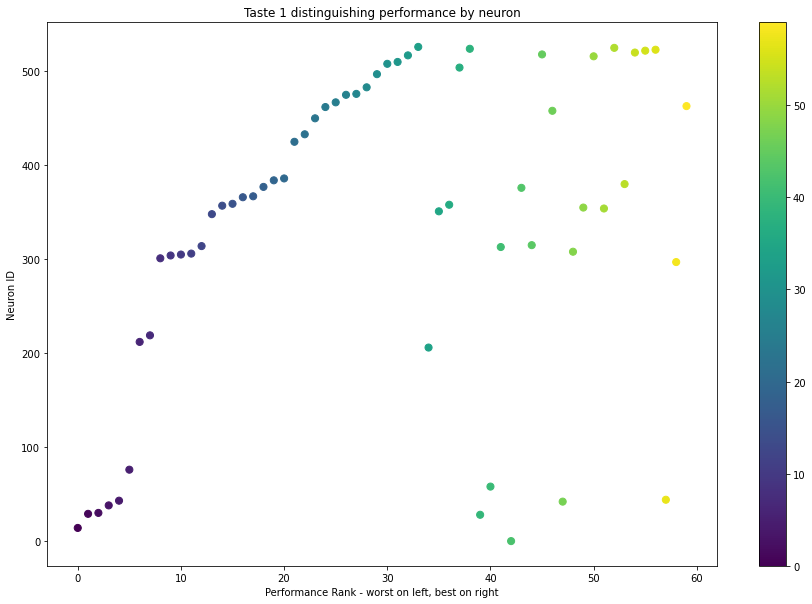

In [47]:
#want to plot index on a line, labeled with column 2 info, colored by what place in line it is.
plt.figure(figsize=(15,10))
xvals = [i for i in range(len(sort_ls))]
yvals = np.zeros(shape=(len(sort_ls),1))
t=xvals
plt.scatter(xvals,y,c=t,cmap='viridis', s=50)
plt.colorbar()
plt.title('Taste 1 distinguishing performance by neuron')
plt.xlabel('Performance Rank - worst on left, best on right')
plt.ylabel('Neuron ID')
plt.show()

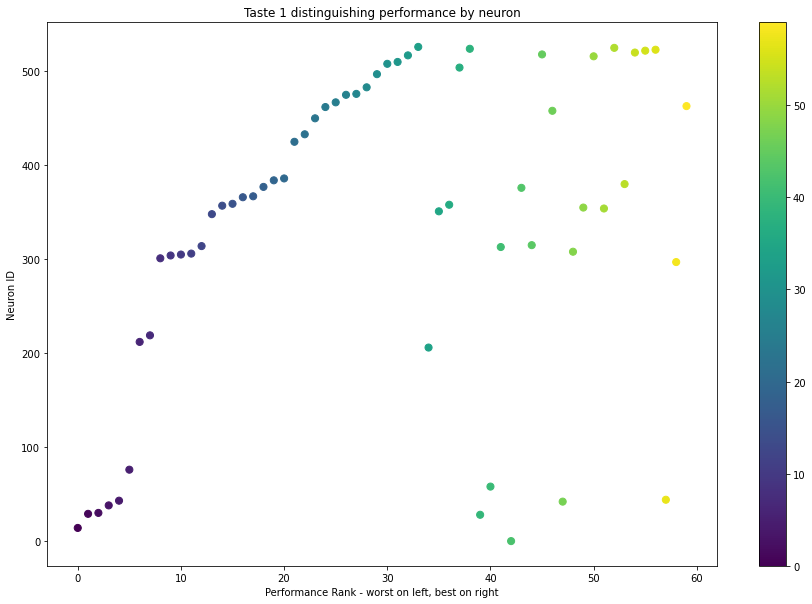

In [48]:
plt.figure(figsize=(15,10))
xvals = [i for i in range(len(sort_ls))]
yvals = np.zeros(shape=(len(sort_ls),1))
t=xvals
plt.scatter(xvals,y,c=t,cmap='viridis', s=50)
plt.colorbar()
plt.title('Taste 1 distinguishing performance by neuron')
plt.xlabel('Performance Rank - worst on left, best on right')
plt.ylabel('Neuron ID')
plt.show()

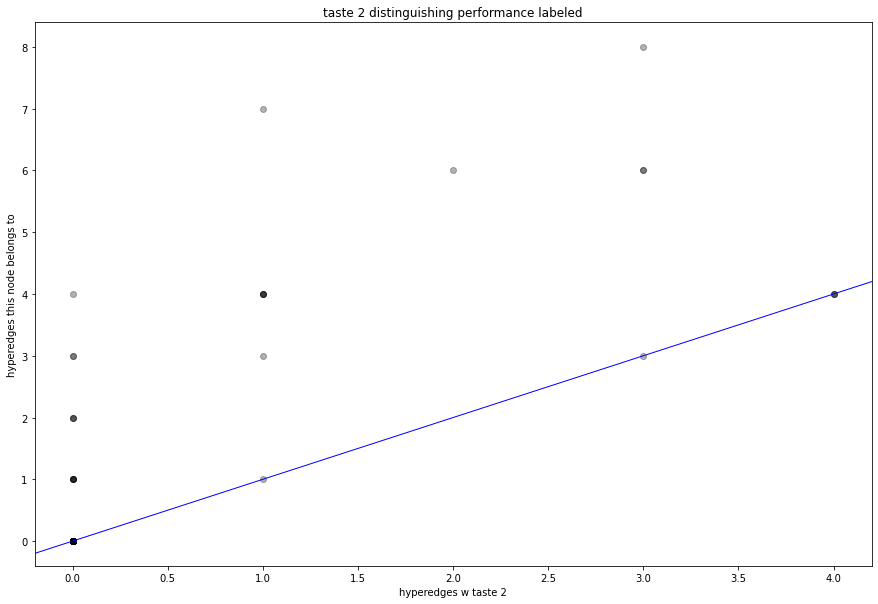

In [49]:
plt.figure(figsize=(15,10))
for i in range(len(sort_ls)):
    plt.scatter(sort_ls[i][0],sort_ls[i][1], label=i, c='k', alpha =0.3)
    label = f"({coding_neurons[i]})"
    plt.annotate(label, (i,sort_ls[i][2]), textcoords="offset points", xytext=(0,5),
                 ha='center')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('taste 2 distinguishing performance labeled')
plt.axline((0, 0), (3, 3), linewidth=1, color='b', label = 'Identity Warping')
plt.xlabel('hyperedges w taste 2')
plt.ylabel('hyperedges this node belongs to')
plt.show()

In [ ]:
dist_mat_r.shape

## Visualize the Rate data

In [50]:
#fill in distinguish: if the entry for dist between these two tastes is bigger than mean+ std, gets a 1.
#fill node size:
distinguishr = np.zeros(shape =(len(coding_neurons),5,5))
node_sizer = []
for coding_neuron in range(len(dist_mat_r)):
    for taste1 in range(5): #row of taste matrix
        for taste2 in range(5): #column of taste matrix
            threshr = np.mean(dist_mat_r[:,taste1,taste2]) +np.std(dist_mat_r[:,taste1,taste2])
            if (dist_mat_r[coding_neuron,taste1,taste2] > threshr):
                distinguishr[coding_neuron,taste1,taste2] = 1
            else:
                distinguishr[coding_neuron,taste1,taste2] = 0
    node_sizer.append(np.sum(distinguishr[coding_neuron])/2)

In [51]:
sum(distinguishr[:,0,3])

10.0

In [52]:
sum(dist_mat_r[:,0,3])

0.0008036239459698891

In [53]:
np.argwhere(np.isnan(dist_mat_r))

array([], shape=(0, 3), dtype=int64)

In [54]:
coding_neurons[47]

497

In [55]:
#node labels is coding_neurons. 
#node size is given by np.sum(distinguish[node])/2 
#edge if two neurons can distinguish the same (if distinguish[coding_neuron,taste1,taste2] is the same, count. divide by 2.)
#edge weight is given by the count above.

nodesr = [i for i in range(len(dist_mat_r))]
nodes_labels_nodesizer = list(zip(nodesr, coding_neurons, node_sizer))

Create a weighted adjacency matrix for the graph and make it available for export.

In [56]:
#lets make weighted edges
weighted_adjr = np.zeros(shape = (len(distinguishr),len(distinguishr)))
for row in range(len(distinguishr)):
    for column in range(len(distinguishr)):
        if (row != column):
            weighted_adjr[row,column] = edgeweight_finder(row,column,distinguishr)
        else:
            weighted_adjr[row,column] = 0.

In [57]:
node_size_dictr = {nodesr[i]: node_sizer[i].astype(int) for i in range(len(nodesr))}
relabel_dictr = {nodesr[i]: coding_neurons[i] for i in range(len(nodesr))}
#res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

In [58]:
G = nx.from_numpy_array(weighted_adjr, parallel_edges=False)
nx.set_node_attributes(G, node_size_dictr, name="size")
H = nx.relabel_nodes(G, relabel_dictr)

In [59]:
nx.write_gexf(H,"rate_only_edges.gexf")

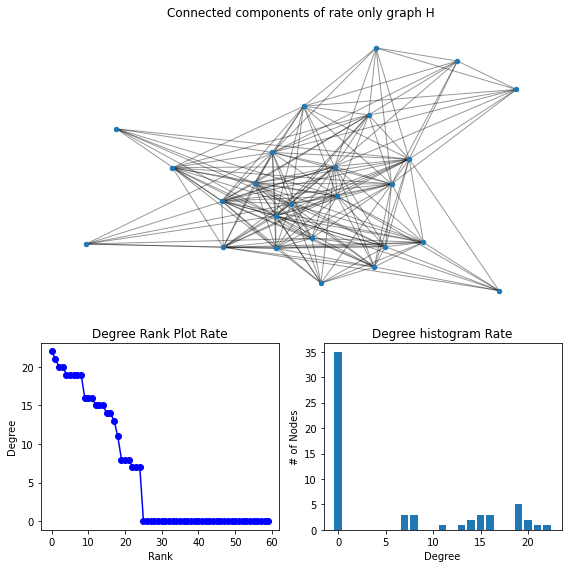

In [60]:
degree_sequence = sorted((d for n, d in H.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Hcc = H.subgraph(sorted(nx.connected_components(H), key=len, reverse=True)[0])
pos = nx.spring_layout(Hcc, seed=10396953)
nx.draw_networkx_nodes(Hcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Hcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of rate only graph H")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot Rate")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram Rate")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [61]:
sum(dist_mat_r[:,0,3])

0.0008036239459698891

now, visualize the data through MDS:

In [23]:
mds_input = np.zeros(shape=(len(coding_neurons),10))
counter = 0
for coding_neuron in range(len(dist_mat_r)):
    for row in range(0,len(dist_mat_r[0])-1):
        for column in range(row+1, len(dist_mat_r[0])):
            mds_input[coding_neuron,counter%10] = dist_mat_r[coding_neuron,row,column]
            counter = counter + 1

In [24]:
mds_input.shape

(529, 10)

In [25]:
embedding = MDS(n_components=2)
input_transformed = embedding.fit_transform(mds_input[:])
input_transformed.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(529, 2)

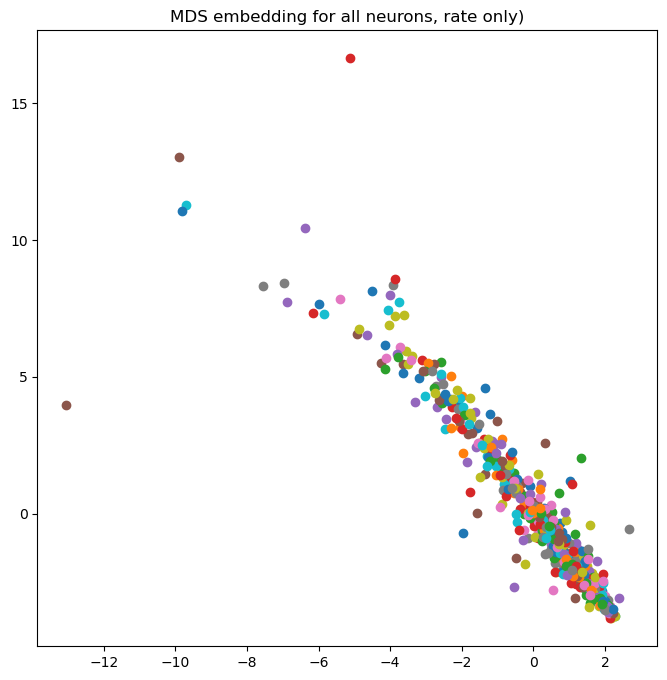

In [27]:
for i in range(len(input_transformed)):
    plt.scatter(input_transformed[i,0]*100,input_transformed[i,1]*100, label=i)
    #label = f"({coding_neurons[i]})"
    #plt.annotate(label, (input_transformed[i,0]*100,input_transformed[i,1]*100), textcoords="offset points", xytext=(0,5),
                # ha='center')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('MDS embedding for all neurons, rate only)')
plt.show()

Create a hypernetwork to visualize the data. Here, we only include points that /do/ distinguish 1+ tastes. This more easily shows which taste pairs two neurons share.

In [65]:
#hypernetx from same data:
#want a dict tastepairs = {01: (distinguish[:,0,1] == 1), 02: (), 03: (), 04:(), 12:(), 13:(), 14:(), 23:(), 24:(), 34:()}

#maybe make array into a pands df and then can rename columns and rows by the dict.
hyperedge_dict_rate = {}
#iterate here over upper triangle - diag in each coding neuron matrix
for row in range(0, len(distinguishr[0])-1):
    for column in range(row+1, len(distinguishr[0])):
        #print(row,column)
        key = row, column
        ls = distinguishr[:,row,column] == 1.
        n = [i for i, x in enumerate(ls) if x]
        #maybe change n values here by dictionary relabel_dict?
        hyperedge_dict_rate[key] = n

In [66]:
hyperedge_dict_rate

{(0, 1): [0, 6, 22, 25, 26, 51, 54, 55, 56, 58],
 (0, 2): [8, 14, 25, 34, 40, 42, 51, 54, 55, 56, 58],
 (0, 3): [6, 19, 22, 24, 25, 32, 40, 51, 56, 58],
 (0, 4): [0, 2, 6, 20, 25, 51, 56, 58],
 (1, 2): [2, 6, 8, 14, 25, 26, 42, 53],
 (1, 3): [0, 9, 19, 25, 26, 54, 55, 56],
 (1, 4): [25, 26, 54, 55, 56],
 (2, 3): [8, 14, 19, 34, 42, 54, 55, 56],
 (2, 4): [8, 14, 34, 40, 42, 54, 55],
 (3, 4): [0, 2, 19, 21, 24, 32, 38, 40, 45]}

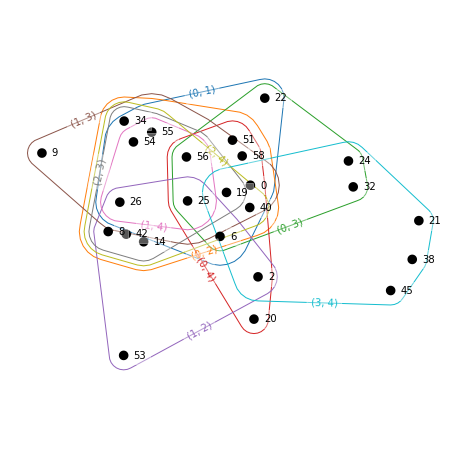

In [67]:
Hypernetr = hnx.Hypergraph(hyperedge_dict_rate)
hnx.draw(Hypernetr)

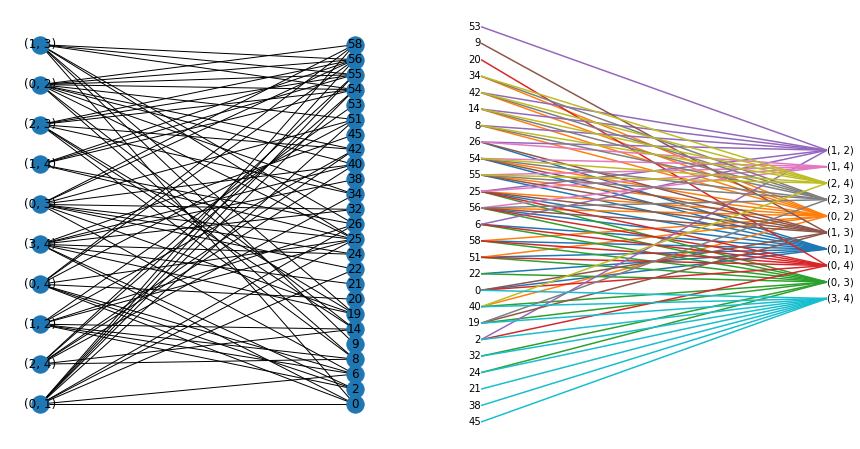

In [68]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
BHr = Hypernetr.bipartite()
top = nx.bipartite.sets(BHr)[0]
pos = nx.bipartite_layout(BHr, top)
nx.draw(BHr, with_labels=True,pos=pos,ax=ax[0])
hnx.drawing.two_column.draw(Hypernetr,ax=ax[1])

here: also create the dual hypergraph. also visualizes only the neurons that distinguish at least one taste pair, and now neurons are hyperedges and the nodes are taste pairs.

In [69]:
hyper_back_rate = {}

edge_names_r = [i for i in range(10)]
edge_values_r = []
for row in range(0, len(distinguishr[0])-1):
    for column in range(row+1, len(distinguishr[0])):
        edge_values_r.append((row, column))

keylistr = [i for i in range(len(distinguishr))]
for key in keylistr:
    ls = []
    for edge in edge_names_r:
        if distinguishr[key][edge_values_r[edge][0]][edge_values_r[edge][1]] == 1:
            item = (edge_values_r[edge][0], edge_values_r[edge][1])
            ls.append(item)
    if ls:
    #    item = (0,0)
    #    ls.append(item)
        hyper_back_rate[key] = ls

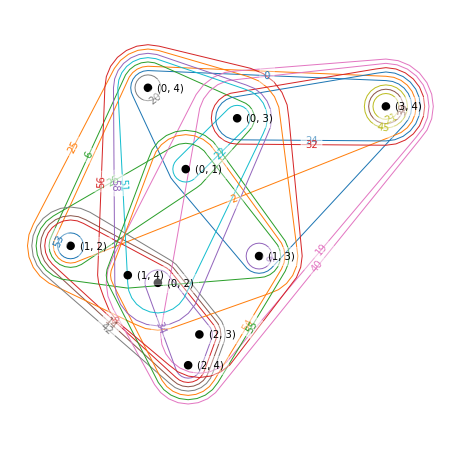

In [70]:
backHypernetrate = hnx.Hypergraph(hyper_back_rate)
hnx.draw(backHypernetrate)

create hierarchical clustering from a phase hypergraph's information. Once visualized, we can compare the phase and rate hypergraphs more easily. 

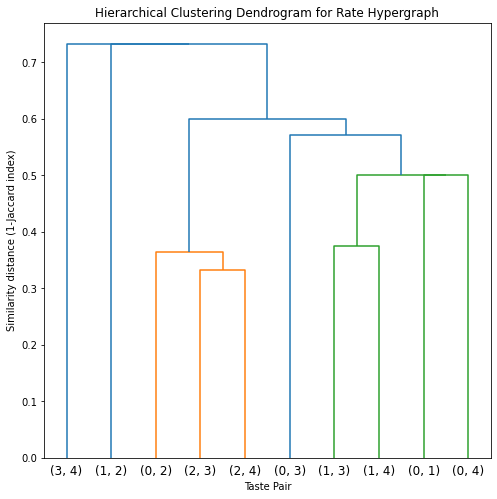

In [71]:
RateSimMat = dict_to_simMat(hyperedge_dict_rate)
X = [i for i in range(10)]
new_labels_rate = list(hyperedge_dict_rate.keys())

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity = 'precomputed', linkage = 'single')

model = model.fit(RateSimMat)
plt.title("Hierarchical Clustering Dendrogram for Rate Hypergraph")
# plot the top three levels of the dendrogram
plot_dendrogram(model, new_labels_rate)
plt.ylabel("Similarity distance (1-Jaccard index)")
plt.xlabel("Taste Pair")
#plt.xticks(X,new_labels)
plt.show()

In [72]:
# Get first value of dictionary: [dict item][key or val?][node_list_ID]
first_value_rate = list(hyperedge_dict_rate.items())[0][1][1]
list(hyperedge_dict_rate.items())

[((0, 1), [0, 6, 22, 25, 26, 51, 54, 55, 56, 58]),
 ((0, 2), [8, 14, 25, 34, 40, 42, 51, 54, 55, 56, 58]),
 ((0, 3), [6, 19, 22, 24, 25, 32, 40, 51, 56, 58]),
 ((0, 4), [0, 2, 6, 20, 25, 51, 56, 58]),
 ((1, 2), [2, 6, 8, 14, 25, 26, 42, 53]),
 ((1, 3), [0, 9, 19, 25, 26, 54, 55, 56]),
 ((1, 4), [25, 26, 54, 55, 56]),
 ((2, 3), [8, 14, 19, 34, 42, 54, 55, 56]),
 ((2, 4), [8, 14, 34, 40, 42, 54, 55]),
 ((3, 4), [0, 2, 19, 21, 24, 32, 38, 40, 45])]

## Rate PCA

In [ ]:
pcar = PCA() # Initialize the model
pcar.fit(mds_input) # fit the model to our data matrix

In [ ]:
prVec0 = pca.components_[0]
prVec1 = pca.components_[1]

projectedphaser = []

# Now we linearly project every sample in our dataset onto the two-dimensional subspace spanned by the first 
# two singular vectors
for j in range(len(coding_neurons)):
    projectedphaser.append([np.dot(mds_input[j],prVec0),np.dot(mds_input[j],prVec1)])

projectedphaser = np.array(projectedphaser)

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(projectedphaser[:, 0], projectedphaser[:, 1])

plt.title('Rate PCA')
plt.xlabel('pVec0')
plt.ylabel('pVec1')
plt.axis('equal')

Figure for ATE writeup: img that may make a good dendrogram.

In [ ]:
neuron_ID = 0
neuron_tp_df = clean_spike_train_df[(clean_spike_train_df['Neuron'] == neuron_ID)] 
neuron_tp_df = truncate(neuron_tp_df)
neuronDF = neuron_tp_df[(neuron_tp_df['Recording Type'] == 'Neuron')]
LickDF = neuron_tp_df[(neuron_tp_df['Recording Type'] == 'Lick')]

kde_xvals, kde_scores = ot_prep_phase(20, neuronDF, LickDF)

In [ ]:
#np.save("taste0forWFR",kde_scores, allow_pickle=True)
#np.save("taste0forWFR0",kde_xvals, allow_pickle=True)

Plot of KDE treatment of phase: used in ATE doc.

In [ ]:
fig, (axs1, axs2, axs3, axs4, axs5) = plt.subplots(1,5, figsize = (15,5), sharex=True, sharey=True)

axs1.plot(kde_xvals[0], kde_scores[0], label='Taste 0')
axs2.plot(kde_xvals[1], kde_scores[1], label='Taste 1', color='orange')
axs3.plot(kde_xvals[2], kde_scores[2], label='Taste 2',color='green')
axs4.plot(kde_xvals[3], kde_scores[3], label='Taste 3',color='red')
axs5.plot(kde_xvals[4], kde_scores[4], label='Taste 4',color='purple')

#axs1.set(xlabel='Time (ms)', ylabel='Normalized Density')
axs1.set_ylabel('Normalized Density', fontsize = 12)
axs1.set_xlabel('Time (ms)', fontsize = 12)
axs2.set_xlabel('Time (ms)', fontsize = 12)
axs3.set_xlabel('Time (ms)', fontsize = 12)
axs4.set_xlabel('Time (ms)', fontsize = 12)
axs5.set_xlabel('Time (ms)', fontsize = 12)

axs1.legend(loc='upper left',fontsize="12")
axs2.legend(loc='upper left',fontsize="12")
axs3.legend(loc='upper left',fontsize="12")
axs4.legend(loc='upper left',fontsize="12")
axs5.legend(loc='upper left',fontsize="12")

fig.suptitle('Kernel Density Estimation for Taste Data From Neuron 0', fontsize='12')
plt.savefig('kde_neuron0.png',bbox_inches='tight', pad_inches=0.25)
plt.show()